In [8]:
from dotenv import load_dotenv

load_dotenv()

True

In [1]:
import time
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langchain_core.runnables.config import RunnableConfig
from langchain_core.messages import HumanMessage
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama

In [2]:

class AgentState(TypedDict):
    question: str
    answer: str

In [ ]:
def call_model(state: AgentState, config: RunnableConfig) -> AgentState:
    model_type = config["configurable"].get("model_type", "openai")
    if model_type == "ollama":
        print("Using Ollama (deepseek-r1:7b).")
        llm = ChatOllama(model="deepseek-r1", temperature=0)
    else:
        print("Using (Gemma2-9b-It).")
        llm =ChatGroq(groq_api_key="",model_name="llama-3.1-8b-instant")

    messages = [HumanMessage(content=state["question"])]
    response = llm.invoke(messages)
    state["answer"] = response.content
    return state

In [4]:
workflow = StateGraph(AgentState)
workflow.add_edge(START, "agent")
workflow.add_node("agent", call_model)
workflow.add_edge("agent", END)
graph = workflow.compile()
ollama_config = {
    "configurable": {
        "model_type": "ollama"
    }
}
graph.invoke({"question": "What's the highest mountain in the world?"}, ollama_config)

Using Ollama (deepseek-r1:7b).


{'question': "What's the highest mountain in the world?",
 'answer': '<think>\n\n</think>\n\nThe highest mountain in the world is Mount Everest.'}

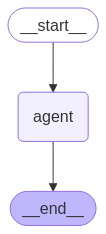

In [5]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [6]:
import re
import time
from langgraph.graph import StateGraph

class ModelSwitcher:
    def __init__(self, graph: StateGraph):
        self.graph = graph
        self.last_openai_fail_time = None
        self.openai_config = {
            "configurable": {
                "model_type": "gemma",
            }
        }
        self.fallback_config = {
            "configurable": {
                "model_type": "ollama",
            }
        }

    def invoke(self, question: str, remove_think: bool = True) -> str:
        if self._should_skip_openai():
            return self._invoke_fallback(question, remove_think)

        if question.lower() == "force error":
            print("Forcing error with ChatGroq.")
            self.last_openai_fail_time = time.time()
            print("OpenAI is disabled for 5 minutes. Invoking fallback.")
            return self._invoke_fallback(question, remove_think)

        try:
            print("Attempting invocation with Gemma...")
            state = {"question": question, "answer": ""}
            result = self.graph.invoke(state, self.openai_config)
            answer = result["answer"]
            return self._clean_if_needed(answer, remove_think)
        except Exception as e:
            print("Error with ChatGroq occurred:", e)
            self.last_openai_fail_time = time.time()
            print("Gemma is disabled for 5 minutes. Invoking fallback.")
            return self._invoke_fallback(question, remove_think)

    def _invoke_fallback(self, question: str, remove_think: bool) -> str:
        print("Using fallback (Ollama).")
        state = {"question": question, "answer": ""}
        result = self.graph.invoke(state, self.fallback_config)
        answer = result["answer"]
        return self._clean_if_needed(answer, remove_think)

    def _should_skip_openai(self) -> bool:
        if self.last_openai_fail_time is None:
            return False
        elapsed = time.time() - self.last_openai_fail_time
        if elapsed < 300:
            remaining = 300 - elapsed
            print(f"Gemma is still in cooldown. Time until Gemma is active again: {remaining:.2f} seconds.")
            return True
        return False

    def _clean_if_needed(self, text: str, remove_think: bool) -> str:
        if not remove_think:
            return text
        return self._remove_thinking_tokens(text)

    def _remove_thinking_tokens(self, text: str) -> str:
        pattern = r"<think>.*?</think>"
        text_no_think = re.sub(pattern, "", text, flags=re.DOTALL)
        return text_no_think.lstrip("\n")

In [7]:
model_switcher = ModelSwitcher(graph)
model_switcher.invoke("What's the highest mountain in the world?")
model_switcher.invoke("force error")
model_switcher.invoke("Which city is the capital of France?")
model_switcher.invoke("Which city is the capital of France?")
model_switcher.invoke("Which city is the capital of France?", remove_think=False)

Attempting invocation with Gemma...
Using (Gemma2-9b-It).
Forcing error with ChatGroq.
OpenAI is disabled for 5 minutes. Invoking fallback.
Using fallback (Ollama).
Using Ollama (deepseek-r1:7b).
Gemma is still in cooldown. Time until Gemma is active again: 280.02 seconds.
Using fallback (Ollama).
Using Ollama (deepseek-r1:7b).
Gemma is still in cooldown. Time until Gemma is active again: 276.32 seconds.
Using fallback (Ollama).
Using Ollama (deepseek-r1:7b).
Gemma is still in cooldown. Time until Gemma is active again: 273.55 seconds.
Using fallback (Ollama).
Using Ollama (deepseek-r1:7b).


'<think>\n\n</think>\n\nThe capital of France is Paris.'